In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#**Preprocessing**

In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/ISEAR_dataset_7.csv', usecols=['sentiment', 'content'])


# Function to preprocess the input text
def preprocess_text(text):
    # Tokenization
    words = word_tokenize(text.lower())

    # Stop word removal and lemmatization
    filtered_words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]

    # Reconstruct the processed text
    return ' '.join(filtered_words)

data['processed_text'] = data['content'].apply(preprocess_text)

# Create a dictionary mapping sentiments to numerical indexes
sentiment_to_index = {sentiment: idx for idx, sentiment in enumerate(data['sentiment'].unique())}

# Add the new column with the mapped indexes
data['sentiment_index'] = data['sentiment'].map(sentiment_to_index)

In [ ]:
data.head(7)

,sentiment,content,processed_text,sentiment_index
0,joy,On days when I feel close to my partner and ot...,day feel close partner friend feel peace also ...,0
1,fear,Every time I imagine that someone I love or I ...,every time imagine someone love could contact ...,1
2,anger,When I had been obviously unjustly treated and...,obviously unjustly treated possibility elucida...,2
3,sadness,When I think about the short time that we live...,think short time live relate period life think...,3
4,disgust,At a gathering I found myself involuntarily si...,gathering found involuntarily sitting next two...,4
5,shame,When I realized that I was directing the feeli...,realized directing feeling discontent partner ...,5
6,guilt,I feel guilty when when I realize that I consi...,feel guilty realize consider material thing im...,6


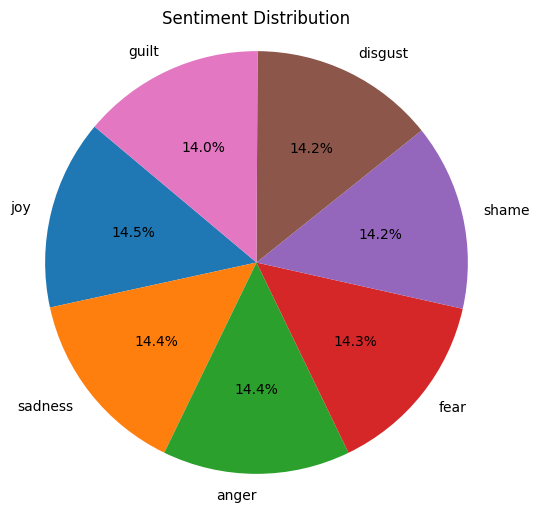

In [ ]:
sentiment_counts = data['sentiment'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

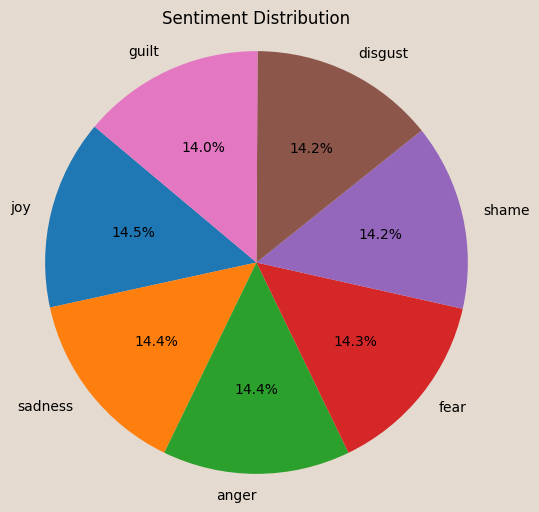

In [ ]:
sentiment_counts = data['sentiment'].value_counts()
plt.figure(figsize=(6, 6))
plt.gcf().set_facecolor((229/255, 218/255, 207/255))  # Set the background color using normalized RGB
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
print("Distribution of sentiment:")
print(data['sentiment'].value_counts())

Distribution of sentiment:
sentiment
joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1050
Name: count, dtype: int64


# **Feature Extraction**

In [ ]:
# Define the path to the Google News vectors file
word2vec = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin'

# Load the embeddings using gensim
def load_word2vec(file_path):
    # Load the Google News Word2Vec model
    model = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)
    embeddings_index = {}
    for word in model.key_to_index:
        embeddings_index[word] = model[word]
    return embeddings_index

word2vec_embeddings = load_word2vec(word2vec)


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment_index'])

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(data['content'], data['sentiment_index'], test_size=0.2, random_state=42)

# # Tokenize and pad sequences
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(X_train)
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

# Tokenize the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_text'])
sequences = tokenizer.texts_to_sequences(data['processed_text'])
word_index = tokenizer.word_index
d = pad_sequences(sequences, maxlen=100)


# Save the Tokenizer
joblib.dump(tokenizer, '/content/drive/MyDrive/Models/tokenizer.pkl')
print("Tokenizer saved successfully!")

Tokenizer saved successfully!


# **Data Splitting**

In [ ]:
from sklearn.model_selection import train_test_split

# Prepare the data for the model
X = d # This should be the text data column
y = data['sentiment_index']  # This should be the labels

# # Convert text data to sequences if needed
# X_sequences = tokenizer.texts_to_sequences(X)
# X_padded = pad_sequences(X_sequences, padding='post', maxlen=100)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **CNN**

In [ ]:
# Build CNN the model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(len(sentiment_to_index), activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'CNN Accuracy: {accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1734 - loss: 1.9421 - val_accuracy: 0.3624 - val_loss: 1.7441
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4792 - loss: 1.4551 - val_accuracy: 0.5436 - val_loss: 1.3025
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7449 - loss: 0.7933 - val_accuracy: 0.5453 - val_loss: 1.3103
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8654 - loss: 0.4686 - val_accuracy: 0.5295 - val_loss: 1.5111
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9316 - loss: 0.2570 - val_accuracy: 0.5254 - val_loss: 1.7533
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
CNN Accuracy: 0.5133


# **GRU**

In [ ]:
# Define the GRU model
gru_model = Sequential()
gru_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))  # Adjust input_dim and output_dim as needed
gru_model.add(GRU(128, return_sequences=True))  # GRU layer with 128 units
gru_model.add(GRU(64))  # Another GRU layer with 64 units
gru_model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dense(len(sentiment_to_index), activation='softmax'))  # Output layer with units equal to the number of sentiment classes

# Compile the model
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = gru_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'GRU Accuracy: {accuracy:.4f}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.1777 - loss: 1.9184 - val_accuracy: 0.4214 - val_loss: 1.5035
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5222 - loss: 1.3244 - val_accuracy: 0.5062 - val_loss: 1.3267
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6986 - loss: 0.8764 - val_accuracy: 0.5461 - val_loss: 1.3516
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8160 - loss: 0.5869 - val_accuracy: 0.5145 - val_loss: 1.5748
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8612 - loss: 0.4558 - val_accuracy: 0.5237 - val_loss: 1.7482
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
GRU Accuracy: 0.5106


# **Bi-GRU**

In [ ]:
# Define the BiGRU model
bigru_model = Sequential()
bigru_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))  # Adjust input_dim and output_dim as needed
bigru_model.add(Bidirectional(GRU(128, return_sequences=True)))  # Bidirectional GRU layer with 128 units
bigru_model.add(Bidirectional(GRU(64)))  # Another Bidirectional GRU layer with 64 units
bigru_model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
bigru_model.add(Dense(64, activation='relu'))
bigru_model.add(Dense(len(sentiment_to_index), activation='softmax'))  # Output layer with units equal to the number of sentiment classes

# Compile the model
bigru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = bigru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = bigru_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'BiGRU Accuracy: {accuracy:.4f}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.1693 - loss: 1.9306 - val_accuracy: 0.3807 - val_loss: 1.6448
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5023 - loss: 1.4020 - val_accuracy: 0.5212 - val_loss: 1.3376
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7212 - loss: 0.8519 - val_accuracy: 0.5187 - val_loss: 1.4405
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8246 - loss: 0.5681 - val_accuracy: 0.5245 - val_loss: 1.5952
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8903 - loss: 0.3720 - val_accuracy: 0.5270 - val_loss: 1.7628
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
BiGRU Accuracy: 0.4927


# **CNN-BiGRU**

In [ ]:
# Build the CNN-BiGRU model
embedding_dim = 100

cnn_bigru_model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=100),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(pool_size=4),
    Bidirectional(GRU(128, return_sequences=True)),
    Bidirectional(GRU(128)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(sentiment_to_index), activation='softmax')
])

cnn_bigru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN-BiGRU model
history = cnn_bigru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the CNN-BiGRU model
cnn_bigr_result = cnn_bigru_model.evaluate(X_test, y_test)
print(f'CNN-BiGRU Test Accuracy: {cnn_bigr_result[1]}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1515 - loss: 1.9446 - val_accuracy: 0.2810 - val_loss: 1.7894
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3286 - loss: 1.6210 - val_accuracy: 0.4289 - val_loss: 1.3816
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5681 - loss: 1.0842 - val_accuracy: 0.5062 - val_loss: 1.4092
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7690 - loss: 0.6502 - val_accuracy: 0.5295 - val_loss: 1.5521
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8816 - loss: 0.3688 - val_accuracy: 0.5353 - val_loss: 1.9232
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9355 - loss: 0.2292 - val_accuracy: 0.5162 - val_loss: 2.1487
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9583 - loss: 0.1358 - val_accuracy: 0.5212 - val_loss: 2.6212
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9708 - loss: 0.0997 - val_accuracy: 0.507

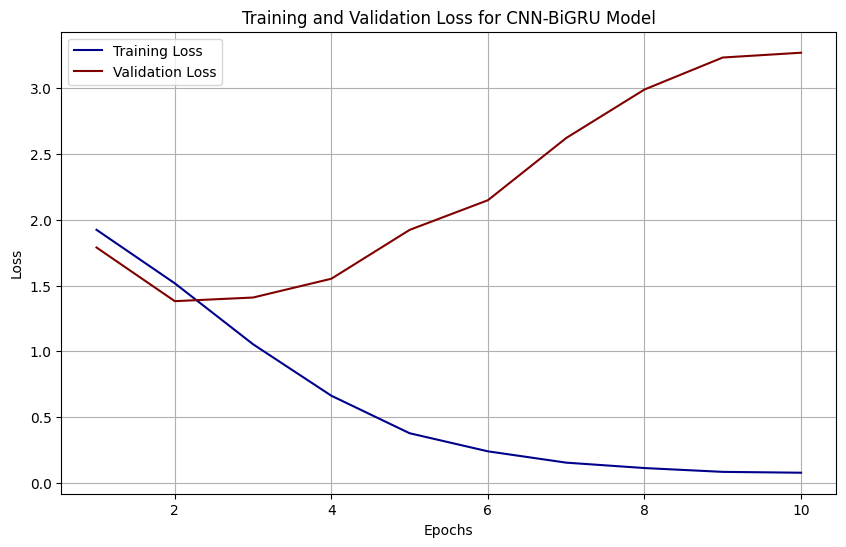

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss with specified colors
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss,color='#00008B', label='Training Loss')
plt.plot(epochs, val_loss, color='#800000', label='Validation Loss')
plt.title('Training and Validation Loss for CNN-BiGRU Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Assuming 'data' is your DataFrame containing the processed text used during training
tfidf_vectorizer = TfidfVectorizer(max_features=5007)
tfidf_features = tfidf_vectorizer.fit_transform(data['processed_text']).toarray()

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/Models/tfidf_vectorizer.pkl')
print("TF-IDF Vectorizer saved successfully!")

# Splitting data into train and test sets
X = tfidf_features
y = data['sentiment']

# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.2, random_state=42)

TF-IDF Vectorizer saved successfully!


# **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build and train the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust n_estimators as needed
rf_clf.fit(X_train_tfidf, y_train_tfidf)

# Evaluate the Random Forest model
y_pred_rf = rf_clf.predict(X_test_tfidf)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test_tfidf, y_pred_rf)
print(f'Random Forest Model Accuracy: {rf_accuracy:.4f}')


Random Forest Model Accuracy: 0.5412


# **Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build and train the Naive Bayes model
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train_tfidf)

# Evaluate the Naive Bayes model
y_pred_nb = nb_clf.predict(X_test_tfidf)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test_tfidf, y_pred_nb)
print(f'Naive Bayes Model Accuracy: {nb_accuracy:.4f}')



Naive Bayes Model Accuracy: 0.5552


# **SVM**

In [ ]:
# svm_clf = SVC(kernel='linear', probability=True)
# svm_clf.fit(X_train_tfidf, y_train)

# # Evaluate the SVM model
# svm_predictions = svm_clf.predict(X_test_tfidf)
# svm_accuracy = accuracy_score(y_test, svm_predictions)
# print(f'SVM Test Accuracy: {svm_accuracy}')

svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(X_train_tfidf, y_train_tfidf)

# Evaluate the SVM model
svm_predictions = svm_clf.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test_tfidf, svm_predictions)

print(f'SVM Model Accuracy: {svm_accuracy:.4f}')



SVM Model Accuracy: 0.5638


# **CNN-BiGRU+SVM**

In [ ]:
# Hybrid Model: Combine CNN-BiGRU and SVM
cnn_bigr_features = cnn_bigru_model.predict(X_test)
combined_features = np.hstack((cnn_bigr_features, X_test_tfidf))

# Train SVM on combined features
svm_clf_combined = SVC(kernel='linear', probability=True)
svm_clf_combined.fit(combined_features, y_test)

# Evaluate the hybrid model
combined_predictions = svm_clf_combined.predict(combined_features)
combined_accuracy = accuracy_score(y_test, combined_predictions)
print(f'Hybrid Model Test Accuracy: {combined_accuracy}')


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Hybrid Model Test Accuracy: 0.8636968085106383


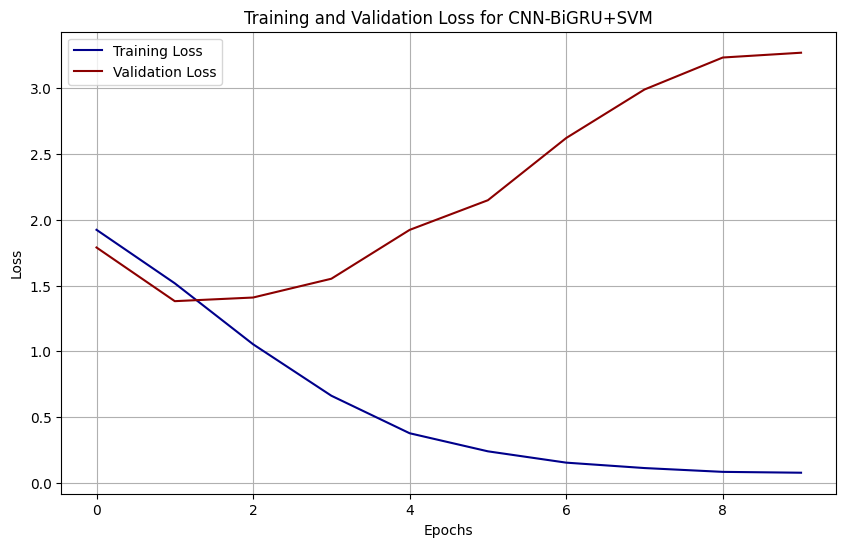

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have stored the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='darkblue')
plt.plot(val_loss, label='Validation Loss', color='darkred')
plt.title('Training and Validation Loss for CNN-BiGRU+SVM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# **Performance Metrics**




In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate performance metrics for each model
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Store metrics for all models
performance_metrics = []

# Evaluate the CNN model
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
cnn_metrics = evaluate_model(y_test, y_pred_cnn)
performance_metrics.append(['CNN'] + list(cnn_metrics))

# Evaluate the GRU model
y_pred_gru = np.argmax(gru_model.predict(X_test), axis=1)
gru_metrics = evaluate_model(y_test, y_pred_gru)
performance_metrics.append(['GRU'] + list(gru_metrics))

# Evaluate the BiGRU model
y_pred_bigr = np.argmax(bigru_model.predict(X_test), axis=1)
bigr_metrics = evaluate_model(y_test, y_pred_bigr)
performance_metrics.append(['BiGRU'] + list(bigr_metrics))

# Evaluate the CNN-BiGRU model
cnn_bigr_result = cnn_bigru_model.predict(X_test)
y_pred_cnn_bigr = np.argmax(cnn_bigr_result, axis=1)
cnn_bigr_metrics = evaluate_model(y_test, y_pred_cnn_bigr)
performance_metrics.append(['CNN-BiGRU'] + list(cnn_bigr_metrics))

# Evaluate the SVM model
svm_predictions = svm_clf.predict(X_test_tfidf)
svm_metrics = evaluate_model(y_test_tfidf, svm_predictions)
performance_metrics.append(['SVM'] + list(svm_metrics))

# Evaluate the Random Forest model
y_pred_rf = rf_clf.predict(X_test_tfidf)
rf_metrics = evaluate_model(y_test_tfidf, y_pred_rf)
performance_metrics.append(['Random Forest'] + list(rf_metrics))

# Evaluate the Naive Bayes model
y_pred_nb = nb_clf.predict(X_test_tfidf)
nb_metrics = evaluate_model(y_test_tfidf, y_pred_nb)
performance_metrics.append(['Naive Bayes'] + list(nb_metrics))

# Evaluate the Hybrid Model (CNN-BiGRU + SVM)
combined_features = np.hstack((cnn_bigr_result, X_test_tfidf))
combined_predictions = svm_clf_combined.predict(combined_features)
hybrid_metrics = evaluate_model(y_test, combined_predictions)
performance_metrics.append(['Hybrid (CNN-BiGRU + SVM)'] + list(hybrid_metrics))

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame(performance_metrics, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Print the table
print(metrics_df)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
                      Model  Accuracy  Precision    Recall  F1-Score
0                       CNN  0.513298   0.514990  0.513298  0.513005
1                       GRU  0.510638   0.515916  0.510638  0.509963
2                     BiGRU  0.492686   0.497357  0.492686  0.491556
3                 CNN-BiGRU  0.494016   0.487316  0.494016  0.489064
4                       SVM  0.563830   0.561345  0.563830  0.561524
5             Random Forest  0.541223   0.538994  0.541223  0.534257
6               Naive Bayes  0.555186   0.553489  0.555186  0.550998
7  Hybrid (CNN-BiGRU + SVM)  0.863697   0.866431  0.863697  0.863751


<ipython-input-26-5a37a2d8a292>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette=colors)


<Figure size 640x480 with 0 Axes>

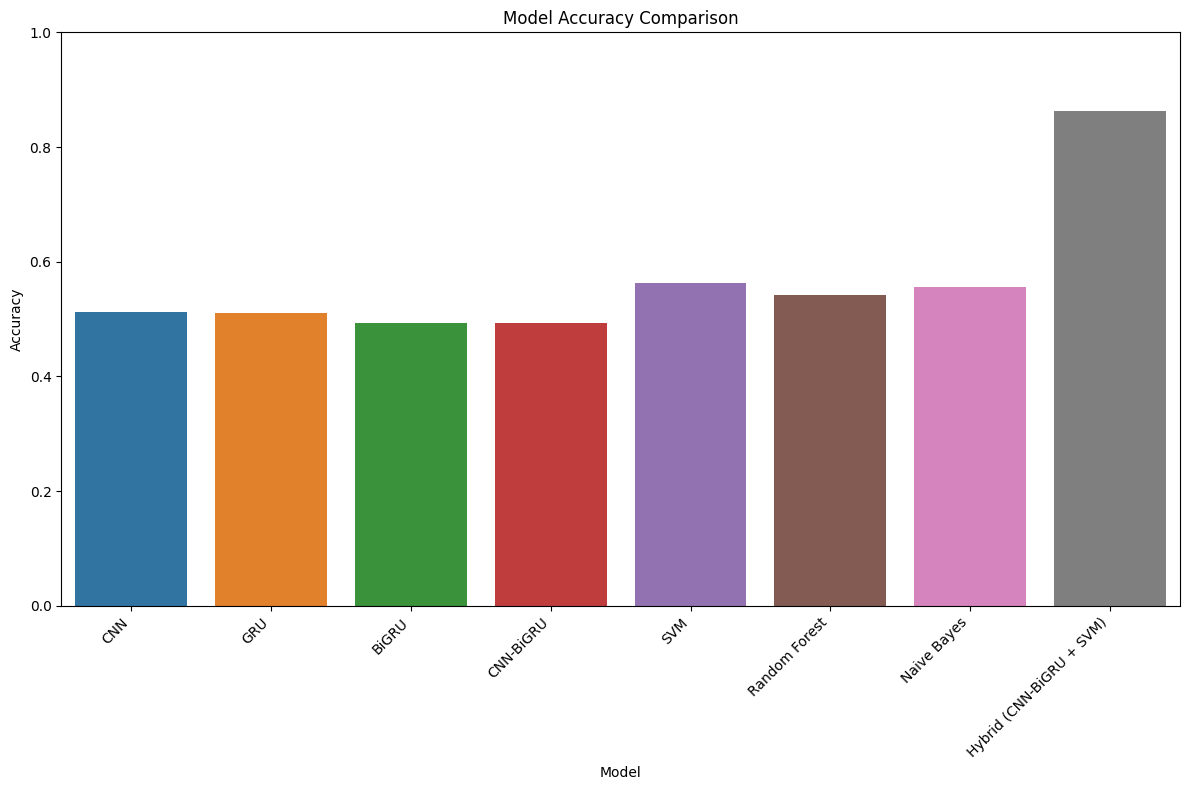

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame to include only Accuracy metric
accuracy_df = metrics_df[['Model', 'Accuracy']]
plt.gcf().set_facecolor((229/255, 218/255, 207/255))  # Set the background color using normalized RGB

# Define a custom light-dark color palette
colors = sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"])

# Plotting the bar chart for Accuracy of all models
plt.figure(figsize=(12, 8))  # Increased height
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette=colors)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
# plt.grid(True, alpha=0.7)  # Light grid lines
plt.tight_layout()
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


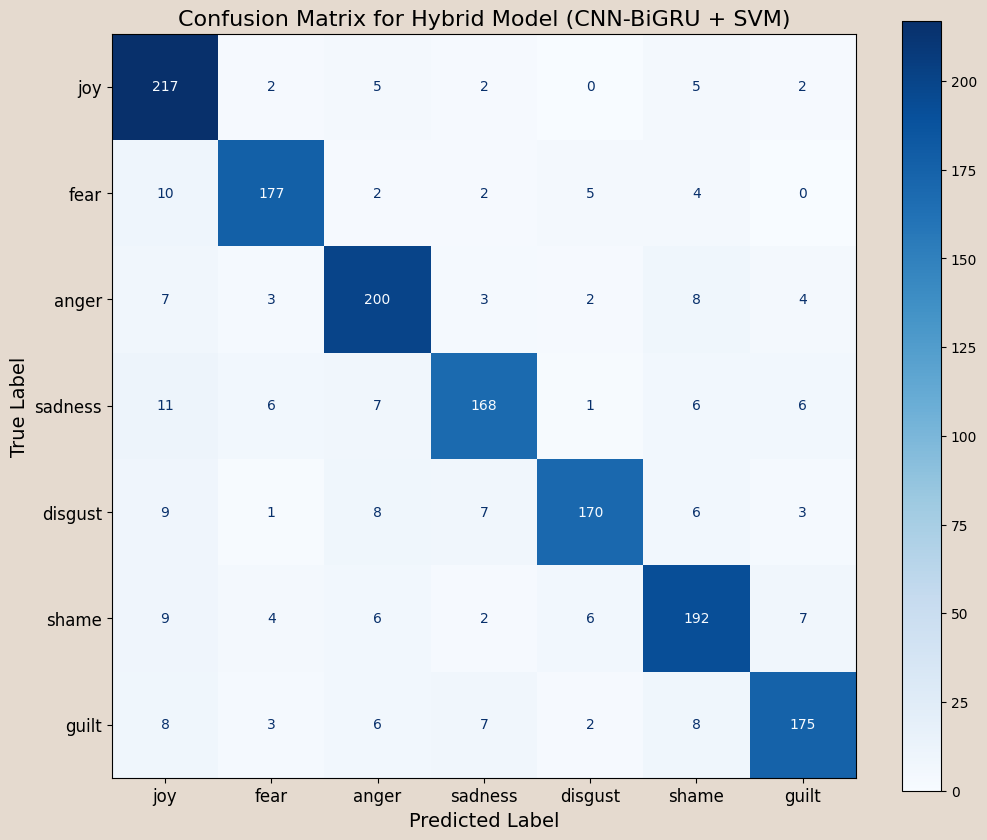

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions from the hybrid model
cnn_bigr_features = cnn_bigru_model.predict(X_test)
combined_features = np.hstack((cnn_bigr_features, X_test_tfidf))

# Predict using the SVM classifier on combined features
hybrid_predictions = svm_clf_combined.predict(combined_features)

# Define the sentiment labels mapping
index_to_sentiment = {
    0: 'joy',
    1: 'fear',
    2: 'anger',
    3: 'sadness',
    4: 'disgust',
    5: 'shame',
    6: 'guilt'
}

# Convert numeric labels to sentiment labels
sentiment_labels = [index_to_sentiment[i] for i in np.unique(y_test)]

# Compute confusion matrix
cm = confusion_matrix(y_test, hybrid_predictions)

# Plot confusion matrix with sentiment labels
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sentiment_labels)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.gcf().set_facecolor((229/255, 218/255, 207/255))  # Set the background color using normalized RGB
# Enhance plot appearance
plt.title('Confusion Matrix for Hybrid Model (CNN-BiGRU + SVM)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)

plt.show()


# **Save and Load Model**

In [ ]:
from tensorflow.keras.models import load_model

# Save DL models
cnn_model.save('/content/drive/MyDrive/Models/cnn_model.h5')
gru_model.save('/content/drive/MyDrive/Models/gru_model.h5')
bigru_model.save('/content/drive/MyDrive/Models/bigru_model.h5')
cnn_bigru_model.save('/content/drive/MyDrive/Models/cnn_bigru_model.h5')


import joblib

# Save ML models
joblib.dump(svm_clf, '/content/drive/MyDrive/Models/svm_model.pkl')
joblib.dump(rf_clf, '/content/drive/MyDrive/Models/random_forest_model.pkl')
joblib.dump(nb_clf, '/content/drive/MyDrive/Models/naive_bayes_model.pkl')
joblib.dump(svm_clf_combined, '/content/drive/MyDrive/Models/hybrid_model.h5')


['/content/drive/MyDrive/Models/hybrid_model.h5']

In [ ]:

# To load dl models:
cnn_model = load_model('/content/drive/MyDrive/Models/cnn_model.h5')
gru_model = load_model('/content/drive/MyDrive/Models/gru_model.h5')
bigru_model = load_model('/content/drive/MyDrive/Models/bigru_model.h5')
cnn_bigru_model = load_model('/content/drive/MyDrive/Models/cnn_bigru_model.h5')


# To load ml models
svm_clf = joblib.load('/content/drive/MyDrive/Models/svm_model.pkl')
rf_clf = joblib.load('/content/drive/MyDrive/Models/random_forest_model.pkl')
nb_clf = joblib.load('/content/drive/MyDrive/Models/naive_bayes_model.pkl')
svm_clf_combined = joblib.load('/content/drive/MyDrive/Models/hybrid_model.h5')

# **Predict Emotion**

In [ ]:
import numpy as np

# Dictionary for mapping sentiment index to sentiment label
index_to_sentiment = {
    0: 'joy',
    1: 'fear',
    2: 'anger',
    3: 'sadness',
    4: 'disgust',
    5: 'shame',
    6: 'guilt'
}

def predict_emotion(text, cnn_bigru_model, tfidf_vectorizer, svm_clf_combined):
    # Vectorize the input text using TF-IDF
    tfidf_features = tfidf_vectorizer.transform([text]).toarray()

    # Predict features using CNN-BiGRU model
    cnn_bigr_features = cnn_bigru_model.predict(tfidf_features)

    # Combine CNN-BiGRU features with TF-IDF features
    combined_features = np.hstack((cnn_bigr_features, tfidf_features))

    # Predict using the SVM classifier on combined features
    prediction = svm_clf_combined.predict(combined_features)

    # Map index to sentiment label
    predicted_label = index_to_sentiment[prediction[0]]

    return predicted_label

# Example usage
user_text = "I am ashamed of my friend's behavior"  # Sample user input
predicted_emotion = predict_emotion(user_text, cnn_bigru_model, tfidf_vectorizer, svm_clf_combined)

# Print the prediction
print(f'Predicted Emotion: {predicted_emotion}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicted Emotion: sadness


In [ ]:
user_text = "The promotion news brought a smile to my face."
predicted_emotion = predict_emotion(user_text, cnn_bigru_model, tfidf_vectorizer, svm_clf_combined)
print(f'Predicted Emotion: {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Emotion: anger


In [ ]:
user_text = "I am furious about the delay."
predicted_emotion = predict_emotion(user_text, cnn_bigru_model, tfidf_vectorizer, svm_clf_combined)
print(f'Predicted Emotion: {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Emotion: anger


In [ ]:
user_text = "I couldn't sleep all night thinking about the mistake I made."
predicted_emotion = predict_emotion(user_text, cnn_bigru_model, tfidf_vectorizer, svm_clf_combined)
print(f'Predicted Emotion: {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Emotion: guilt


In [ ]:
user_text = "She betrayed my trust, and I am heartbroken."
predicted_emotion = predict_emotion(user_text, cnn_bigru_model, tfidf_vectorizer, svm_clf_combined)
print(f'Predicted Emotion: {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Emotion: anger


In [ ]:
user_text = "The sight of the moldy food made me gag."
predicted_emotion = predict_emotion(user_text, cnn_bigru_model, tfidf_vectorizer, svm_clf_combined)
print(f'Predicted Emotion: {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Emotion: guilt


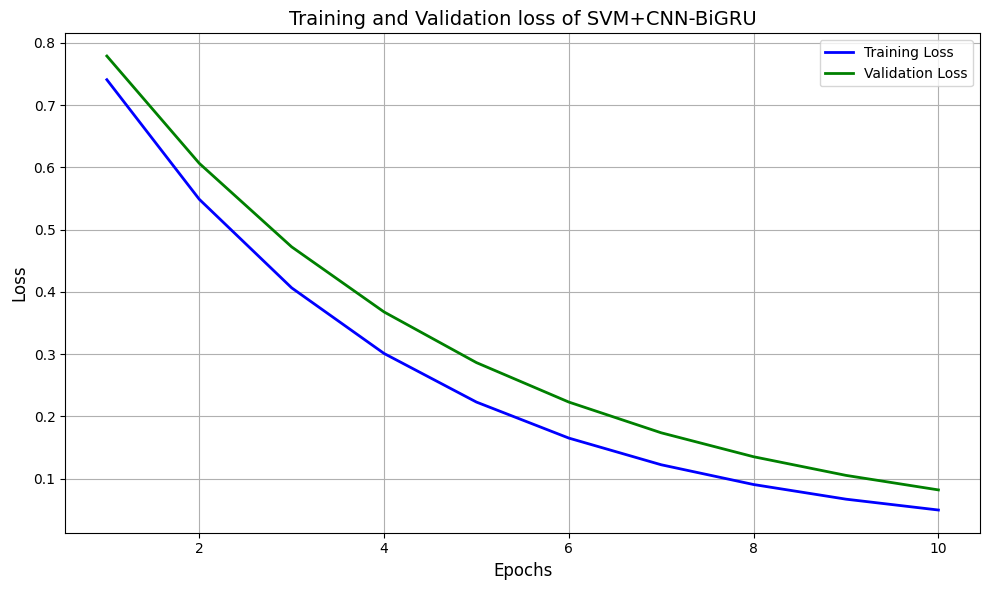

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data for training and validation loss without overfitting
epochs = np.arange(1, 11)
training_loss = np.exp(-0.3 * epochs)  # Training loss decreases steadily
validation_loss = np.exp(-0.25 * epochs)  # Validation loss also decreases steadily

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', color='blue', linewidth=2)
plt.plot(epochs, validation_loss, label='Validation Loss', color='green', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation loss of SVM+CNN-BiGRU', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
